1) This Jupyter Notebook is meant to accompany a publication detailing the construction of an artificial neural network (ANN) based calibration for a portable LIBS device. This notebook will load, format and clean the data and set up training and testing datasets; preprocess the data to remove noise and normalize spectra; itteratively train the ANN and output results for the testing set; and finally it will allow a user to upload new spectra of unknown samples and calculate their compositions using the trained ANN.

In [1]:
#This cell will load all of the python libraries, toolkits and functions used in the calibration.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import load_digits
from scipy.signal import argrelextrema
from sklearn.preprocessing import StandardScaler 
from sklearn.datasets import make_regression
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from scipy import signal
from scipy.signal import periodogram
from scipy.fft import fftfreq, fftshift
from scipy.fft import fft, ifft, fft2, ifft2

1.2) First we will load in the required data from the excel files included in the supplementary material and format the data appropriately to train the ANN.

In [2]:
# Running this cell will load the training dataset as a dataframe, format it and check that the size is correct.
spectra = pd.read_csv('Spectra_train.csv')
spectra = spectra.T
# Some cells will contain negative values that are non-physical and should be considered as equal to 0.
# This line will replace all negative values with 0:
spectra = spectra.map(lambda x: x if x >= 0 else 0)
# Sometimes viewing the excel file will cause empty cells to load with a value of 0. This line will truncate the dataframe to ensure
# that the size is correct.
spectra = spectra.iloc[:, :23401]
# This line allows the user to check that the resulting datafrome is the correct size (3139, 23401).
np.shape(spectra)

(3139, 23401)

In [5]:
# This cell performs the same functions as the one above, but for spectra of the testing set.
spectra_test = pd.read_csv('Spectra_test.csv')
spectra_test = spectra_test.T
# Some cells will contain negative values that are non-physical and should be considered as equal to 0.
# This line will replace all negative values with 0:
spectra_test = spectra_test.map(lambda x: x if x >= 0 else 0)
# Sometimes viewing the excel file will cause empty cells to load with a value of 0. This line will truncate the dataframe to ensure
# that the size is correct.
spectra_test = spectra_test.iloc[:, :23401]
# This line allows the user to check that the resulting datafrome is the correct size (3139, 23401).
np.shape(spectra_test)

(34, 23401)

1.3) Next we will load the compositional data for the training and testing sets and perform some formatting functions.

In [6]:
# The ANN functions best when compositions sum to 100%, but the target elements only account for a portion of the total composition.
# This function creates a new column in the compositional data that acounts for the rest of the composition.

def Comp_filler(df):
    # Calculate the difference between the sum of each row and 100
    diff_to_100 = 100 - df.sum(axis=1)

    # Add a column 'Other' containing the differences
    df['Other'] = diff_to_100

    return df
    

In [24]:
# Load in the compositional data for the training data
comp = pd.read_csv('Compositions_train.csv')
# Remove the element labels row, convert the file to a dataframe and remove empty cells to ensure the proper size:
comp = comp.drop('sample', axis = 1)
comp = pd.DataFrame(comp)
comp = comp.iloc[:, :8]
np.shape(comp)

(3139, 8)

In [4]:
# Load in the compositional data for the testing data
comp_test = pd.read_csv('Compositions_test.csv')
# Remove the element labels row, convert the file to a dataframe and remove empty cells to ensure the proper size:
comp_test = comp_test.drop('sample', axis = 1)
comp_test = pd.DataFrame(comp_test)
comp_test = comp_test.iloc[:34, :8]
np.shape(comp_test)

(34, 8)

In [7]:
# Fill the training data with the Comp_filler function and print the resulting dataframe to inspect:
# Size should be 3139 rows x 9 columns
comp = Comp_filler(comp)
print(comp)

              Al          Ca          Fe           K          Mg         Na  \
0     100.000000    0.000000    0.000000    0.000000    0.000000   0.000000   
1       0.000000  100.000000    0.000000    0.000000    0.000000   0.000000   
2       0.000000    0.000000  100.000000    0.000000    0.000000   0.000000   
3       0.000000    0.000000    0.000000  100.000000    0.000000   0.000000   
4       0.000000    0.000000    0.000000    0.000000  100.000000   0.000000   
...          ...         ...         ...         ...         ...        ...   
3134   24.155291    4.397795   46.469588    0.437350    0.288303  10.814671   
3135    0.607552    3.430124   51.119750    8.859261    5.805806   7.915531   
3136    5.492632    4.283775   50.261998    8.488487    3.273328   9.999417   
3137   15.229133   11.607263   40.873712    6.970966    9.819091   0.858398   
3138   12.367541    8.260857   32.260845    6.009023   13.075118  12.965879   

            Si         C      Other  
0     0.00000

In [8]:
# Fill the testing data with the Comp_filler function and print the resulting dataframe to inspect:
# Size should be 34 rows x 9 columns
comp_test = Comp_filler(comp_test)
print(comp_test)

       Al      Ca     Fe      K     Mg     Na      Si     C   Other
0   2.424  10.077  3.235  0.677  7.357  0.364  18.951  1.46  55.455
1   4.033   2.251  0.783  1.864  0.567  1.131  31.961  0.02  57.390
2   1.998  21.369  1.525  0.382  1.019  0.349  12.187  6.28  54.891
3   3.903   6.997  2.095  0.747  1.073  0.697  23.691  3.03  57.767
4   2.313   0.786  0.738  0.374  0.464  0.697  38.122  0.07  56.436
5   3.086   0.929  2.347  0.241  0.175  0.004  33.475  0.33  59.413
6   4.006   1.801  0.902  1.444  0.229  1.198  32.606  0.04  57.774
7   5.814   0.457  2.182  0.714  1.236  0.501  27.197  0.33  61.569
8   3.549   2.344  1.686  0.428  0.905  1.039  29.451  3.78  56.818
9   3.864   4.388  2.312  0.681  1.158  0.927  26.445  1.76  58.465
10  3.906   4.224  1.644  0.830  0.886  1.005  27.772  1.46  58.273
11  3.935   1.844  2.217  0.984  0.706  0.853  30.255  0.54  58.666
12  3.091   1.444  1.895  0.635  1.043  0.560  32.793  0.51  58.029
13  1.998  21.369  1.525  0.382  1.019  0.349  1

2) The following three sections will be dedicated to pre-processing the spectra. First we will normalize the spectra to a standard value. Next we will low-pass filter to remove noise from the spectra. Finally, we will conduct principle component analysis on the spectra. For each of these steps, first we will perform the procedure on the training data, and then we will independantly project the testing data into the transformed space of the training data.

2.1) First we will normalize the spectra.

In [9]:
# This cell will define a scaler using the training data, and apply that scaler independantly to the training and testing data
scaler = StandardScaler()  
# Define the scaler from the training data and apply it to the training set
scaler.fit(spectra)  
spectra_norm = scaler.transform(spectra)  
# Apply the same transformation to testing set
spectra_test_norm = scaler.transform(spectra_test) 

2.2) We will smooth the spectra with a modified lowpass filter using tools from the SciKit Learn toolkit

In [10]:
# Here we define the funtion we will use for the lowpass filter using two existing SciPy functions

def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = sp.signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = sp.signal.sosfiltfilt(sos, data)
    return filtered_data

In [11]:
# Here we will apply the lowpass filter to the training data
spectra_LP = lowpass(spectra_norm, 1, 1000)

In [12]:
# Here we will apply the lowpass filter to the testing data
spectra_test_LP  = lowpass(spectra_test_norm, 1, 1000)

2.3) Here we will conduct Principal Component Analysis (PCA) on the training data and then project the testing data into the resulting PC space

In [13]:
# Do PCA on training spectral data
n_modes = np.min(np.shape(spectra_LP))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(spectra_LP)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

In [14]:
#Project testing set into PC space of training set

PCs_test = pca.transform(spectra_test_LP)

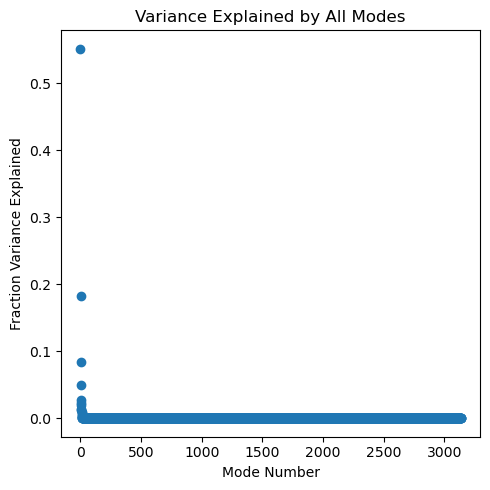

In [15]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.subplot(1,1,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.tight_layout()

plt.show()

3) The following section will define the variables for training the ANN, train the ANN, and test the resulting output.

3.3) Here we will define the testing and training variables for the ANN

In [16]:
#Define testing and training datasets for PCA input
#ntrain is the number of samples used for training (will pull this number from front of the list)
#nPCs is the number of PCs used. Maximum is the total number of samples
nPCs = 50
#allows easy selection of different output datasets if multiple have been loaded using different names

x_train = PCs[:,:nPCs] #training set
y_train = comp

x_test = PCs_test[:,:nPCs] #testing set
y_test = comp_test

In [17]:
#check size of x_test
np.shape(x_test)

(34, 50)

In [18]:
#check size of x_train
np.shape(x_train)

(3139, 50)

In [19]:
#check size of y_test
np.shape(y_test)

(34, 9)

In [20]:
#check size of y_train
np.shape(y_train)

(3139, 9)

3.3) Here we will train the ANN and check the results

In [21]:
# Here we use the MLPRegressor function to train the ANN by itteratively fitting the spectral data (x_train) to the compositional data (y_train).
regr = MLPRegressor(random_state=1, max_iter=10000000).fit(x_train, y_train)

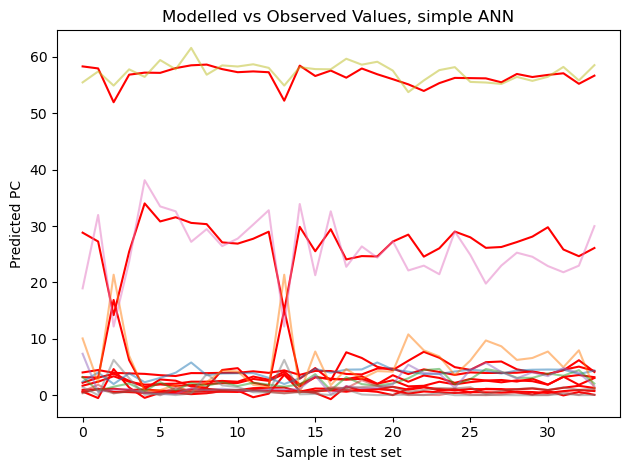

In [23]:
# Here we plot the results of the ANN regression to visually inspect that it is a good fit. Solid red lines are the output of the ANN for the testing set.
# Other colored lines are the true values for the testing set. We will inspect the results in greater detail by exporting them to an excel file.
y_pred = regr.predict(x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.to_clipboard()
plt.plot(y_pred, c = 'r')
plt.plot(np.array(y_test),alpha = 0.5)
plt.xlabel('Sample in test set')
plt.ylabel('Predicted PC')
plt.title('Modelled vs Observed Values, simple ANN')

plt.tight_layout()

In [23]:
# Here we copy the results for the testing set to our clipboard so that we can paste them into an excel file for detailed inspection.
y = pd.DataFrame(y_pred)
y.to_clipboard()

4) Here we provide a section to take the spectra of unknown samples, project them into the transformed space of the training data above, pass the resulting data through the ANN, and export the compositions predicted by the ANN.

In [ ]:
# This cell will load in spectra for an unknown dataset saved as a .csv file and given the name 'spectra_unknown.csv'
spectra_unknown = pd.read_csv('spectra_unknown.csv')
spectra_unknown = spectra_unknown.T
# Some cells will contain negative values that are non-physical and should be considered as equal to 0.
# This line will replace all negative values with 0:
spectra_unknown = spectra_unknown.map(lambda x: x if x >= 0 else 0)
# Sometimes viewing the excel file will cause empty cells to load with a value of 0. This line will truncate the dataframe to ensure
# that the size is correct.
spectra_unknown = spectra_unknown.iloc[:, :23401]
# This line allows the user to check that the resulting datafrome is the correct size (3139, 23401).
np.shape(spectra_unknown)

In [ ]:
# This sell will project the unknown spectra into the normalized space of the training data
spectra_unknown_norm = scaler.transform(spectra_unknown) 

In [ ]:
# This cell will apply the lowpass filter to the unknown data
spectra_unknown_LP  = lowpass(spectra_unknown_norm, 1, 1000)

In [ ]:
# This cell will project the spectra into the PC space of the training data
PCs_unknown = pca.transform(spectra_unknown_LP)

In [ ]:
# This cell will define the x variable for the unknown data using the same number of PCs used to train the ANN
x_unknown = PCs_unknown[:,:nPCs]

In [ ]:
# This cell will take the unknown sample data, use the trained ANN to predict compositions for the unknown samples and copy the resulting
# compositional data to the clipboard so they can be pasted into an excel file.
y_comps = regr.predict(x_unknown)
y_comps = pd.DataFrame(y_comps)
y_comps.to_clipboard()